# Gender classification with Resnet18 on Small Datasets

## Init

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from tensorflow.keras.layers import Rescaling, Flatten, GlobalAveragePooling2D, Layer
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ReLU, Dense
from tensorflow.keras import Model
from keras.models import Sequential

## Init dataset

In [ ]:
%cp "/content/MyDrive/MyDrive/KHDL/SmallDS.zip" "/content"
!unzip "/content/SmallDS.zip" -d "/content"

Archive:  /content/SmallDS.zip
  inflating: /content/SmallDS/test/male_face_image/971.jpg  
  inflating: /content/SmallDS/test/male_face_image/956.jpg  
  inflating: /content/SmallDS/test/male_face_image/913.jpg  
  inflating: /content/SmallDS/test/male_face_image/907.jpg  
  inflating: /content/SmallDS/test/male_face_image/968.jpg  
  inflating: /content/SmallDS/test/male_face_image/960.jpg  
  inflating: /content/SmallDS/test/male_face_image/919.jpg  
  inflating: /content/SmallDS/test/male_face_image/931.jpg  
  inflating: /content/SmallDS/test/male_face_image/943.jpg  
  inflating: /content/SmallDS/test/male_face_image/966.jpg  
  inflating: /content/SmallDS/test/male_face_image/979.jpg  
  inflating: /content/SmallDS/test/male_face_image/985.jpg  
  inflating: /content/SmallDS/test/male_face_image/990.jpg  
  inflating: /content/SmallDS/test/male_face_image/992.jpg  
  inflating: /content/SmallDS/test/male_face_image/944.jpg  
  inflating: /content/SmallDS/test/male_face_image/932

In [ ]:
train_data_folder = "/content/SmallDS/train"
val_data_folder = "/content/SmallDS/val"
test_data_folder = "/content/SmallDS/test"

INPUT_SHAPE = (160, 224, 3)  # aspect ratio = 1.4

# training data
train_dataset = image_dataset_from_directory(train_data_folder,
                                             shuffle=True,
                                             batch_size=64,
                                             image_size=INPUT_SHAPE[:2])

# validation data
validation_dataset = image_dataset_from_directory(val_data_folder,
                                                  shuffle=True,
                                                  batch_size=64,
                                                  image_size=INPUT_SHAPE[:2])

# testing data
test_dataset = image_dataset_from_directory(test_data_folder,
                                            shuffle=True,
                                            batch_size=100,
                                            image_size=INPUT_SHAPE[:2])

print(train_dataset.class_names)
print(validation_dataset.class_names)
print(test_dataset.class_names)

Found 800 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
['female_face_image', 'male_face_image']
['female_face_image', 'male_face_image']
['female_face_image', 'male_face_image']


## Init Model

Sử dụng mô hình deep learning là Resnet18 để trích xuất đặc trưng, sau đó sử dụng một mạng MLP để thực hiện phân loại

In [ ]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        # self.flat = Flatten()
        # self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        # out = self.flat(out)
        # out = self.fc(out)
        return out

In [ ]:
resnet18 = ResNet18()

In [ ]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = Rescaling(scale=1./255.)(inputs)
x = resnet18(x)
x = tf.keras.layers.Dense(120, activation='relu')(x)
x = tf.keras.layers.Dense(84, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, x)
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 224, 3)       0         
                                                                 
 res_net18 (ResNet18)        (None, 512)               11190912  
                                                                 
 dense (Dense)               (None, 120)               61560     
                                                                 
 dense_1 (Dense)             (None, 84)                10164     
                                                                 
 dense_2 (Dense)             (None, 1)                 8

## Training model

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.00001)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=7, min_lr=0.001)
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy')
]
model.compile(optimizer=opt,
              metrics=METRICS,
              loss='binary_crossentropy') 

history = model.fit(train_dataset, epochs=70, validation_data=validation_dataset)

Epoch 1/70
13/13 [==============================] - 45s 353ms/step - loss: 0.5973 - accuracy: 0.7013 - val_loss: 1.8243 - val_accuracy: 0.4800
Epoch 2/70
13/13 [==============================] - 3s 171ms/step - loss: 0.2356 - accuracy: 0.9212 - val_loss: 0.9922 - val_accuracy: 0.5200
Epoch 3/70
13/13 [==============================] - 3s 183ms/step - loss: 0.0573 - accuracy: 0.9925 - val_loss: 1.0073 - val_accuracy: 0.3300
Epoch 4/70
13/13 [==============================] - 3s 194ms/step - loss: 0.0135 - accuracy: 0.9987 - val_loss: 1.6408 - val_accuracy: 0.5000
Epoch 5/70
13/13 [==============================] - 3s 173ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 3.0266 - val_accuracy: 0.5200
Epoch 6/70
13/13 [==============================] - 3s 173ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 3.2568 - val_accuracy: 0.5200
Epoch 7/70
13/13 [==============================] - 3s 173ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 3.4108 - val_accuracy: 0.5200
Epoch

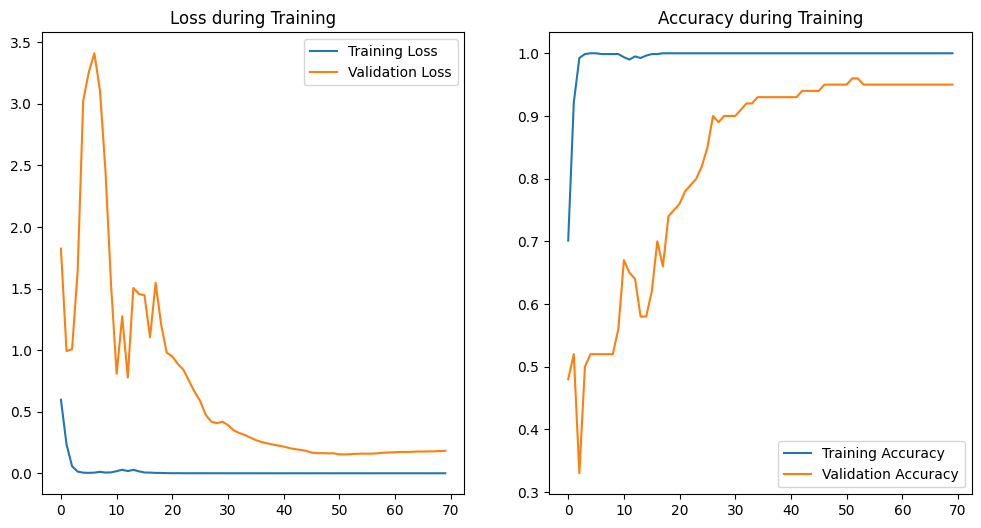

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss during Training")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy during Training")
plt.legend()
plt.show()

→ Nhận xét:
- Quá trình huấn luyện hội tụ tại epoch: 50

In [ ]:
from datetime import datetime
fn = f"{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.h5"
print(f"Save model to {fn}")
model.save(
    os.path.join("/content/MyDrive/MyDrive/KHDL/models", fn)
)

Save model to 2023_05_20_07_11_26.h5


## Evaluate

### Load model

In [ ]:
model = tf.keras.models.load_model(os.path.join("/content/MyDrive/MyDrive/KHDL/models", "2023_05_20_07_11_26.h5"), custom_objects={'ResNet18': ResNet18})

### Accuracy on Test Dataset

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

1/1 - 2s - loss: 0.3023 - accuracy: 0.9400 - 2s/epoch - 2s/step


### Confusion Matrix from Test Dataset's Prediction

In [ ]:
y_pred = model.predict(test_dataset).reshape(-1)
x_test = np.concatenate([x for x, y in test_dataset], axis=0)
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = [(1 if y > 0.5 else 0) for y in y_pred]

1/1 [==============================] - 1s 748ms/step


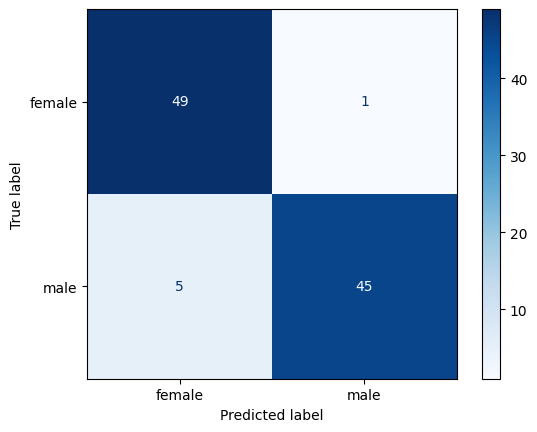

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['female', 'male'])
cm_display.plot(cmap="Blues")
plt.show()

Các trường hợp dự đoán sai trên tập kiểm thử:
- Có 5 trường hợp dự đoán "Nữ" với ảnh gốc là "Nam"
- Có 1 trường hợp dự đoán "Nam" với ảnh gốc là "Nữ"

Nhận xét:
- Độ chính xác: 0.94

### Visulize results from Test Dataset

1/1 [==============================] - 0s 19ms/step


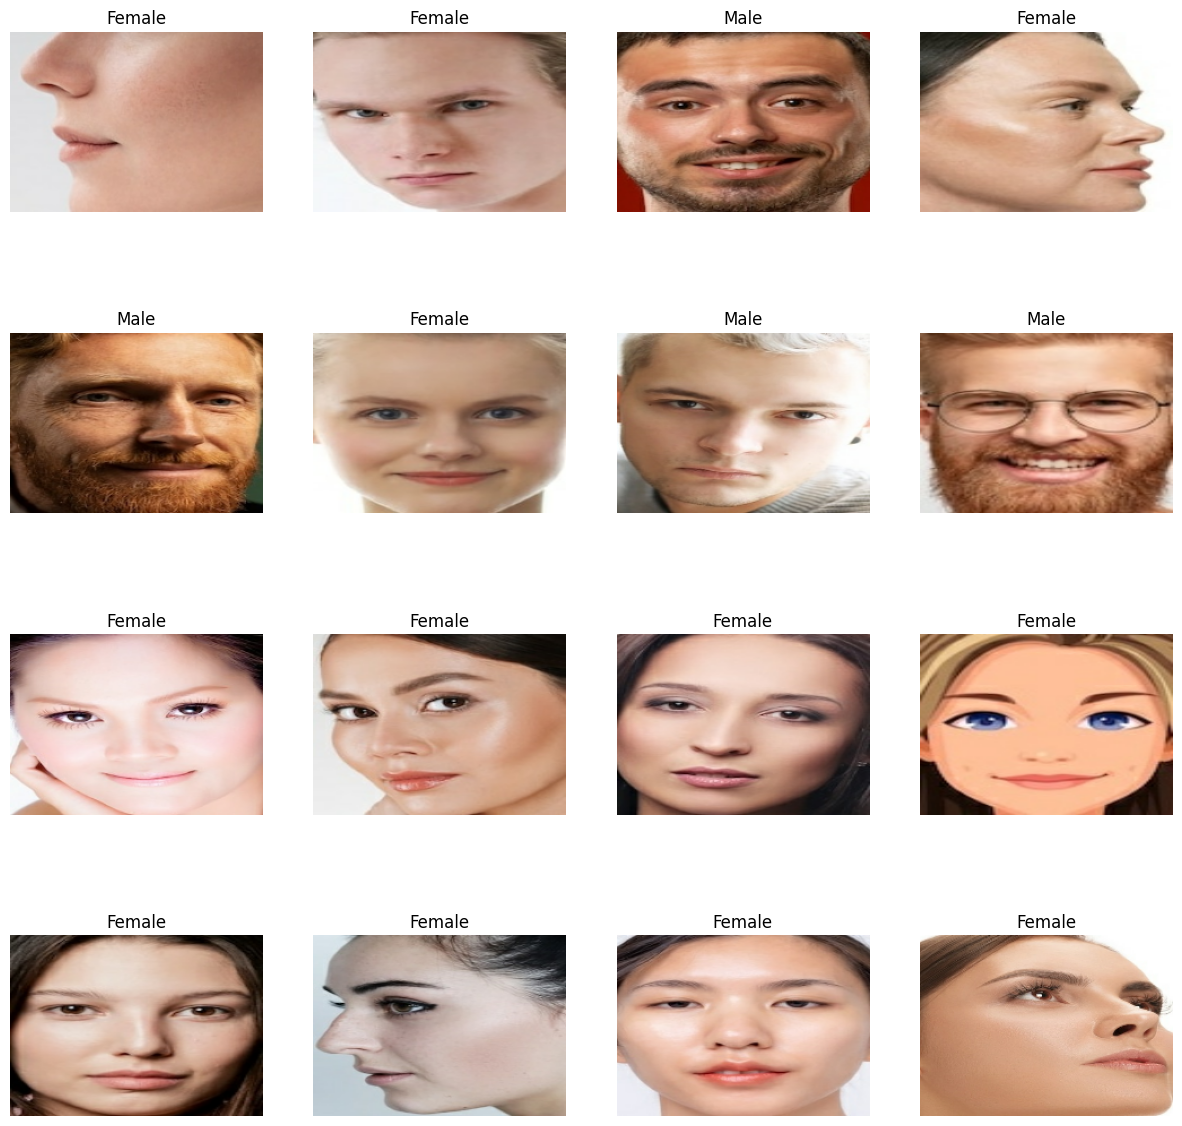

In [ ]:
class_names = test_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    # images (64,224,224,3)
    for i in range(16):
        image = images[i].numpy()
        image = np.expand_dims(image, axis=0)
        result = model.predict(image)
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Male" if result > 0.5 else f"Female")
        plt.axis("off")

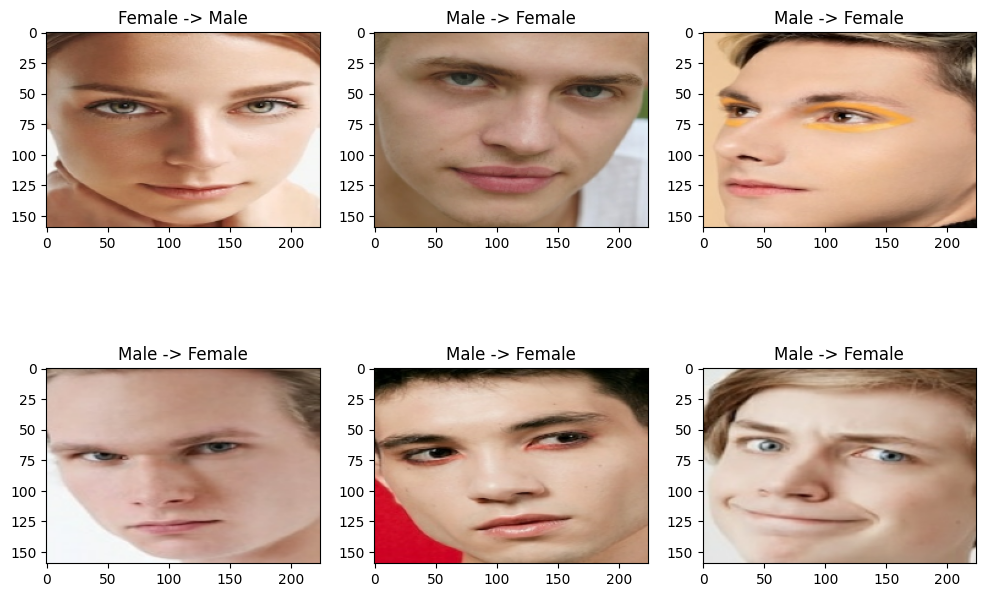

In [ ]:
class_names = test_dataset.class_names
fail_cases = []
j = 1
plt.figure(figsize=(12, 8))
for images, labels in iter(test_dataset):
    for i in range(len(labels)):
        image = images[i].numpy()
        label = labels[i]
        image = np.expand_dims(image, axis=0)
        result = model.predict(image, verbose=0)
        if abs(result[0, 0] - int(label)) > 0.5: # true
            plt.subplot(2, 3, j)
            j += 1
            save_image = images[i].numpy().astype("uint8").copy()
            plt.imshow(save_image)
            fail_cases.append([save_image, int(label), result])
            plt.title("Male -> Female" if label == 1 else "Female -> Male")
plt.show()

# Gender classification with Resnet50 on Big Datasets

## Init 

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from tensorflow.keras.layers import Rescaling, Flatten, GlobalAveragePooling2D, Layer
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ReLU, Dense
from tensorflow.keras import Model
from keras.models import Sequential

## Init dataset

In [ ]:
%cp "/content/MyDrive/MyDrive/KHDL/datasets.zip" "/content"
!unzip "/content/datasets.zip" -d "/content"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/datasets/train/female_face_image/950.jpg  
  inflating: /content/datasets/train/female_face_image/951.jpg  
  inflating: /content/datasets/train/female_face_image/953.jpg  
  inflating: /content/datasets/train/female_face_image/954.jpg  
  inflating: /content/datasets/train/female_face_image/955.jpg  
  inflating: /content/datasets/train/female_face_image/957.jpg  
  inflating: /content/datasets/train/female_face_image/958.jpg  
  inflating: /content/datasets/train/female_face_image/96.jpg  
  inflating: /content/datasets/train/female_face_image/960.jpg  
  inflating: /content/datasets/train/female_face_image/961.jpg  
  inflating: /content/datasets/train/female_face_image/962.jpg  
  inflating: /content/datasets/train/female_face_image/963.jpg  
  inflating: /content/datasets/train/female_face_image/964.jpg  
  inflating: /content/datasets/train/female_face_image/965.jpg  
  inflating: /content/datasets/tra

In [ ]:
train_data_folder = "/content/datasets/train"
val_data_folder = "/content/datasets/val"
test_data_folder = "/content/datasets/test"

INPUT_SHAPE = (160, 224, 3)  # aspect ratio = 1.4

# training data
train_dataset = image_dataset_from_directory(train_data_folder,
                                             shuffle=True,
                                             batch_size=256,
                                             image_size=INPUT_SHAPE[:2])

# validation data
validation_dataset = image_dataset_from_directory(val_data_folder,
                                                  shuffle=True,
                                                  batch_size=64,
                                                  image_size=INPUT_SHAPE[:2])

# testing data
test_dataset = image_dataset_from_directory(test_data_folder,
                                            shuffle=True,
                                            batch_size=1047,
                                            image_size=INPUT_SHAPE[:2])

print(train_dataset.class_names)
print(validation_dataset.class_names)
print(test_dataset.class_names)

Found 8364 files belonging to 2 classes.
Found 1045 files belonging to 2 classes.
Found 1047 files belonging to 2 classes.
['female_face_image', 'male_face_image']
['female_face_image', 'male_face_image']
['female_face_image', 'male_face_image']


## Init Model

Sử dụng mô hình deep learning là Resnet18 để trích xuất đặc trưng, sau đó sử dụng một mạng MLP để thực hiện phân loại

In [ ]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        # self.flat = Flatten()
        # self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        # out = self.flat(out)
        # out = self.fc(out)
        return out

In [ ]:
resnet18 = ResNet18()

In [ ]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = Rescaling(scale=1./255.)(inputs)
x = resnet18(x)
x = tf.keras.layers.Dense(120, activation='relu')(x)
x = tf.keras.layers.Dense(84, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, x)
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 224, 3)       0         
                                                                 
 res_net18_2 (ResNet18)      (None, 512)               11190912  
                                                                 
 dense_6 (Dense)             (None, 120)               61560     
                                                                 
 dense_7 (Dense)             (None, 84)                10164     
                                                                 
 dense_8 (Dense)             (None, 1)                

## Training model

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.00001)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=7, min_lr=0.001)
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy')
]

model.compile(optimizer=opt,
              metrics=METRICS,
              loss='binary_crossentropy') 

history = model.fit(train_dataset, epochs=70, validation_data=validation_dataset)

Epoch 1/70
33/33 [==============================] - 54s 876ms/step - loss: 0.3022 - accuracy: 0.8650 - val_loss: 5.6042 - val_accuracy: 0.4660
Epoch 2/70
33/33 [==============================] - 25s 666ms/step - loss: 0.0906 - accuracy: 0.9658 - val_loss: 1.7263 - val_accuracy: 0.3522
Epoch 3/70
33/33 [==============================] - 24s 686ms/step - loss: 0.0224 - accuracy: 0.9950 - val_loss: 2.7382 - val_accuracy: 0.5321
Epoch 4/70
33/33 [==============================] - 24s 687ms/step - loss: 0.0082 - accuracy: 0.9982 - val_loss: 3.5523 - val_accuracy: 0.5330
Epoch 5/70
33/33 [==============================] - 24s 696ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 2.4615 - val_accuracy: 0.5799
Epoch 6/70
33/33 [==============================] - 25s 675ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 2.0840 - val_accuracy: 0.6411
Epoch 7/70
33/33 [==============================] - 25s 680ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.5660 - val_accuracy: 0.8354

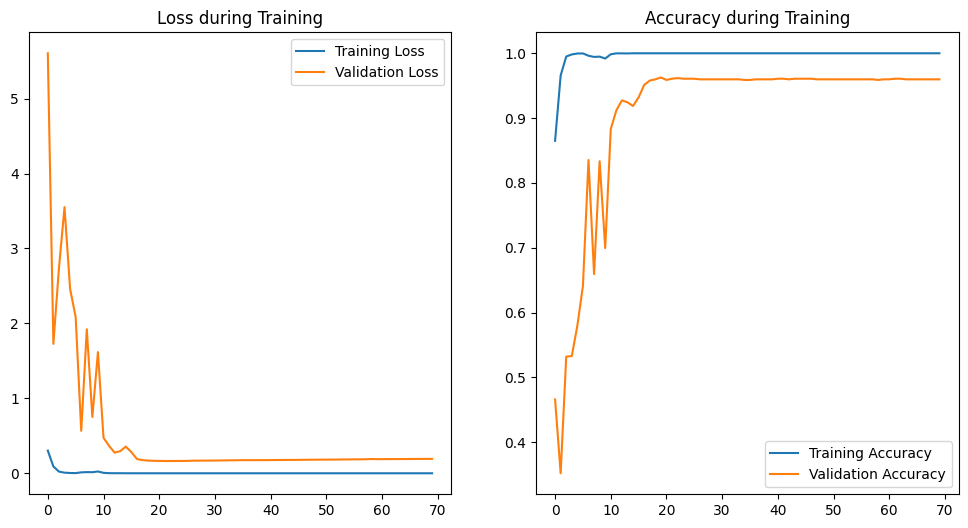

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss during Training")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy during Training")
plt.legend()
plt.show()

→ Nhận xét:
- Mô hình hội tụ từ epoch 20

So sánh với Small Dataset thì tốc độ hội tụ của mô hình trên Medium Dataset nhanh hơn. 

In [ ]:
from datetime import datetime
fn = f"{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.h5"
print(f"Save model to {fn}")
model.save(
    os.path.join("/content/MyDrive/MyDrive/KHDL/models", fn)
)

Save model to 2023_05_20_08_01_53.h5


## Evaluate

### Load model

In [ ]:
model = tf.keras.models.load_model(os.path.join("/content/MyDrive/MyDrive/KHDL/models", "2023_05_20_08_01_53.h5"), custom_objects={'ResNet18': ResNet18})

### Accuracy on Test Dataset

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

1/1 - 12s - loss: 0.1406 - accuracy: 0.9742 - 12s/epoch - 12s/step


### Confusion Matrix from Test Dataset's Prediction

In [ ]:
y_pred = model.predict(test_dataset).reshape(-1)
x_test = np.concatenate([x for x, y in test_dataset], axis=0)
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = [(1 if y > 0.5 else 0) for y in y_pred]

1/1 [==============================] - 2s 2s/step


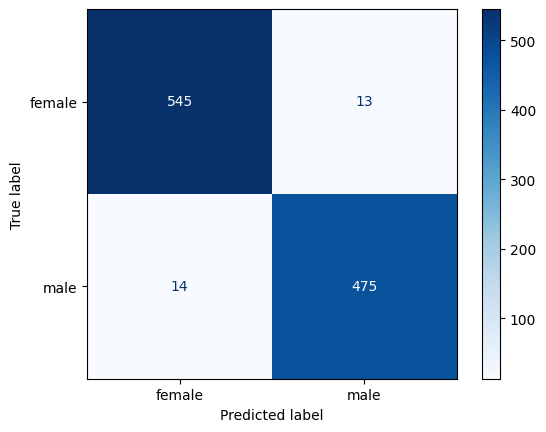

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['female', 'male'])
cm_display.plot(cmap="Blues")
plt.show()

Các trường hợp dự đoán sai:
- Có 14 trường hợp dự đoán Nữ với ảnh gốc là Nam
- Có 13 trường hợp dự đoán Nam với ảnh gốc là Nữ

Nhận xét:
- Độ chính xác: 0.9742
- Kết quả nhận dạng không bị mất cân bằng.

### Visulize Result from Test Dataset's predictions

1/1 [==============================] - 0s 20ms/step


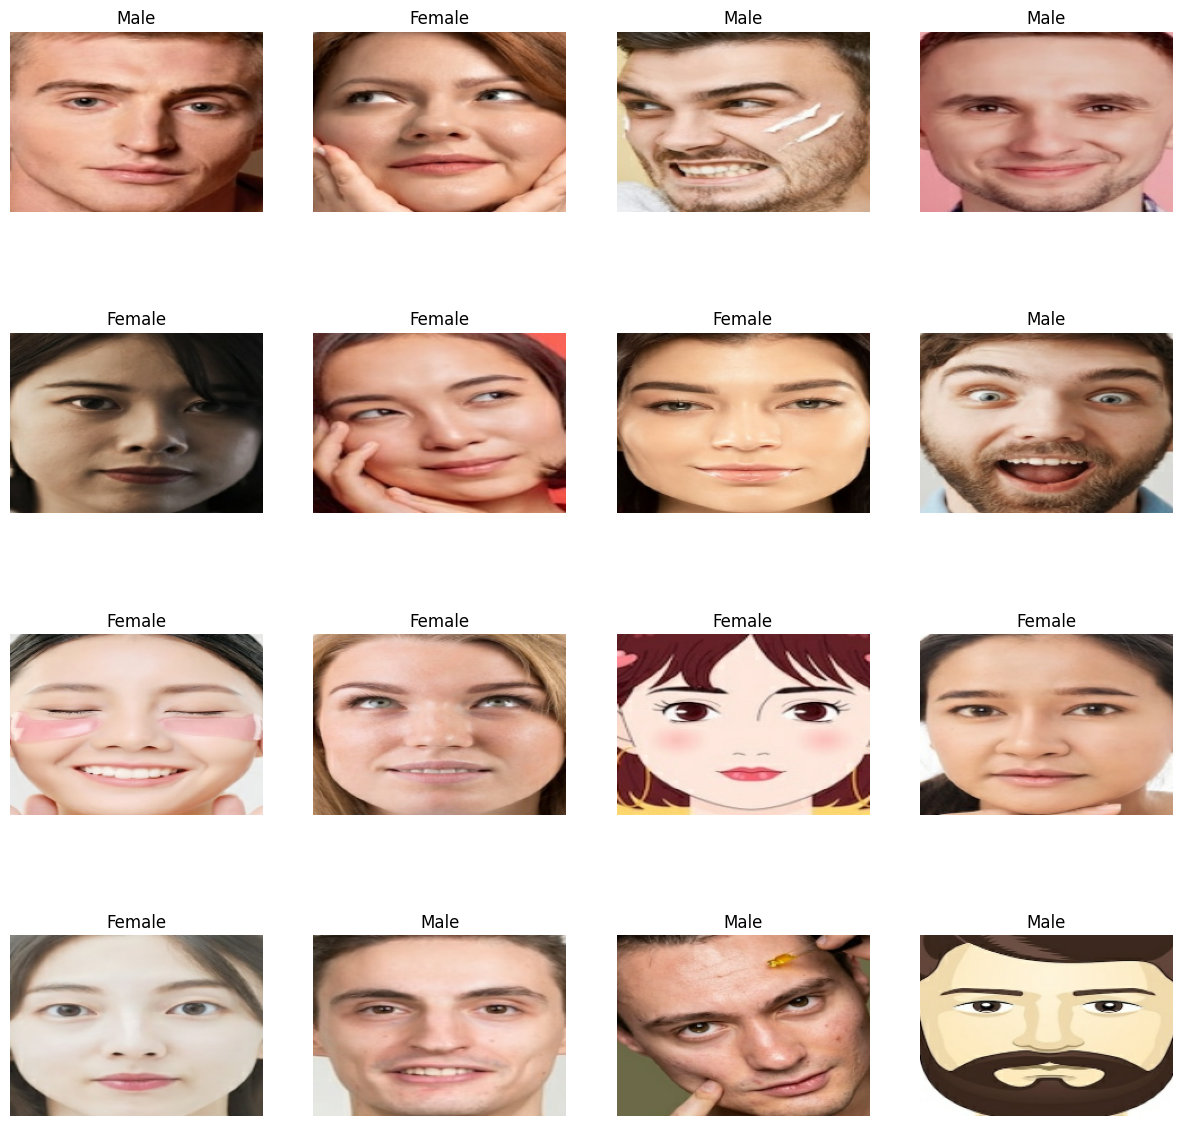

In [ ]:
class_names = test_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    # images (64,224,224,3)
    for i in range(16):
        image = images[i].numpy()
        image = np.expand_dims(image, axis=0)
        result = model.predict(image)
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Male" if result > 0.5 else f"Female")
        plt.axis("off")

### Visulize Test Dataset's Fail Cases

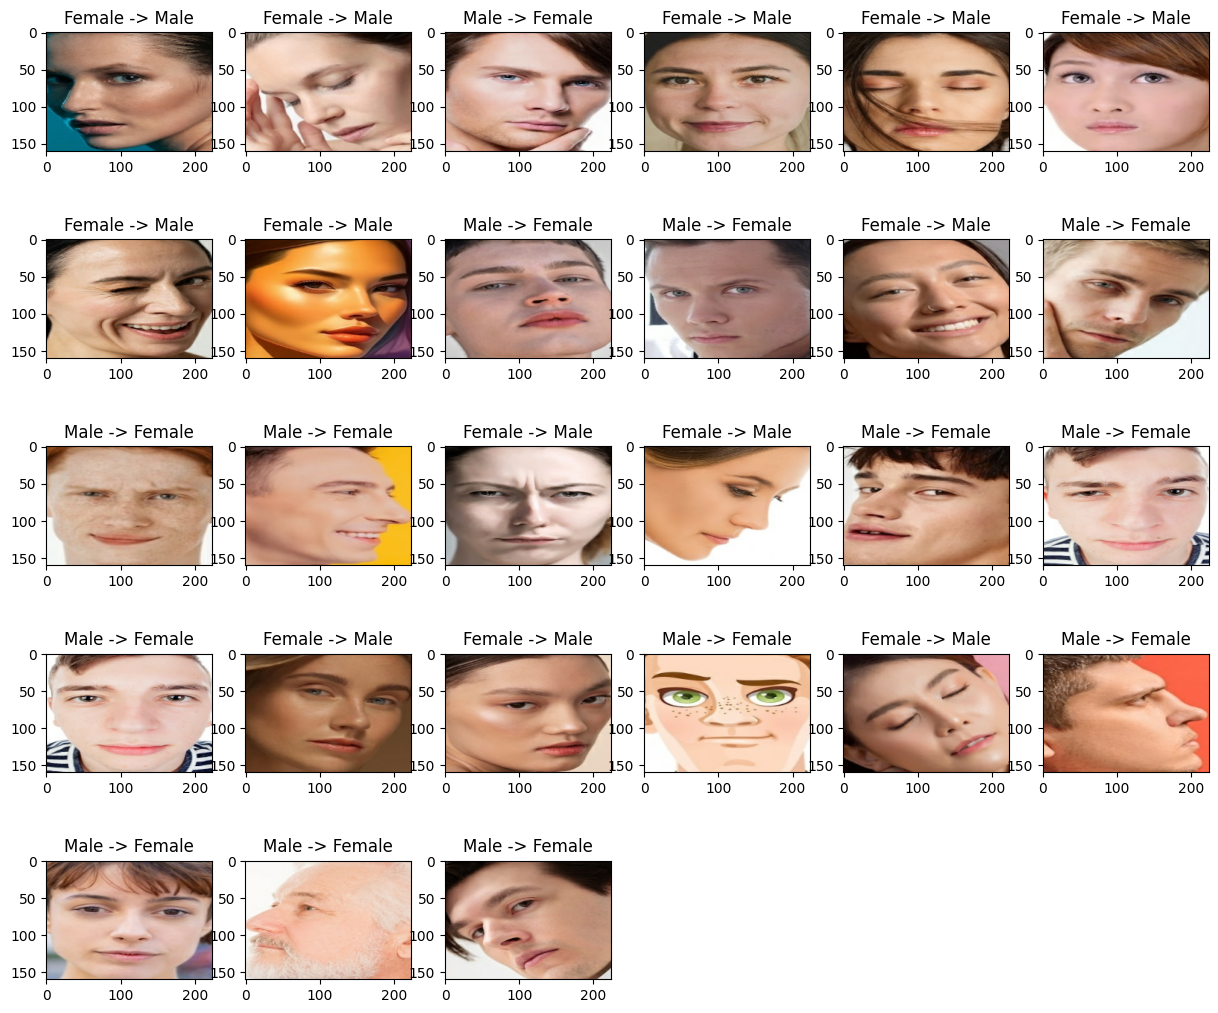

In [ ]:
class_names = test_dataset.class_names
fail_cases = []
j = 1
plt.figure(figsize=(15, 13))
for images, labels in iter(test_dataset):
    for i in range(len(labels)):
        image = images[i].numpy()
        label = labels[i]
        image = np.expand_dims(image, axis=0)
        result = model.predict(image, verbose=0)
        if abs(result[0, 0] - int(label)) > 0.5: # true
            plt.subplot(7, 4, j)
            j += 1
            save_image = images[i].numpy().astype("uint8").copy()
            plt.imshow(save_image)
            fail_cases.append([save_image, int(label), result])
            plt.title("Male -> Female" if label == 1 else "Female -> Male")

# Kết luận
Mô hình đạt được kết quả tốt trên cả tập huấn luyện, đánh giá và kiểm thử.

Với Small Dataset:
- Training Acuracy: 1.0
- Validation Accuracy: 0.95
- Test Accuracy: 0.94

Với Big Dataset:
- Training Accuracy: 1.0
- Validation Accuracy: 0.9598
- Test Accuracy: 0.9742